Data needed in input:
- raw images for A and B assembly in bulk
- segmentation masks (you can produce these using the FIJI Macro at "Fiji utils/RNA_epifluorescence_timelapse_segmentation.ijm" selecting Li thresholding (bulk)
- raw confocal images for A and B condensates in bulk (post 48h assembly)
- segmentation masks derived from confocal images (can be obtained with the same macro or via a simple thresholding step).

Arrange the epifluorescence timelapses in `img_dir`, the derived masks in `mask_dir`, the confocal images in `confocal_img_dir` and the confocal masks in `confocal_mask_dir`. 

In [1]:
# Import dependencies
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

from skimage.morphology import binary_dilation
from tqdm.notebook import tqdm

# Analyse epifluorescence timelapses

In [2]:
# CHANGE THESE TO ABSOLUTE PATHS FOR EPIFLUORESCENCE IMAGE AND BINARY MASK DIRECTORIES
img_dir = "/ABSOLUTE/PATH/TO/IMAGE/DIR/"
mask_dir = "/ABSOLUTE/PATH/TO/MASK/DIR/"

In [3]:
# Define timelapse timepoints
timepoints = np.concatenate([np.linspace(0, 10*60, 41), 
                             np.linspace(10*60 + 30, 48.5*60, 77)], axis = 0)

In [4]:
# Define filepaths for A and B as lists of lists (each containing one image and one mask stack)
filepaths_a = [
    [
        directory + f'MG_A_bulk_{rep}.ome.tif'
        for directory in [img_dir, mask_dir]
    ]
    for rep in [0, 1, 2]
]
filepaths_b = [
    [
        directory + f'DFHBI_B_bulk_{rep}.ome.tif'
        for directory in [img_dir, mask_dir]
    ]
    for rep in [0, 1, 2]
]

In [5]:
def get_dilute_to_condensed_intensity_ratio(filepaths): 
    # Initialise results
    ratio_dilute_over_condensed_intensities = []
    
    # Loop through files
    for filepath_combo in filepaths: 
        # Read image and mask timelapse stacks
        image = cv2.imreadmulti(filepath_combo[0])[1]
        mask = cv2.imreadmulti(filepath_combo[1])[1] # mask is black within condensates, bright outside
        assert len(image) == len(mask), f"Image sequence length {len(image)} is different from that of mask sequence {len(mask)}"
    
        # Temporary accumulation lists
        ratio_dilute_over_condensed_phases = []
                
        for i in tqdm(range(len(image))): 
            # Mask already tracks the dilute phase (condensates dark, background white)
            mask_dilute = np.array(mask[i][:, :, 0])
            # Invert to get condensates
            mask_condensates = ~mask_dilute
            # Intersect image with condensate mask to get condensed phase intensity 
            intersection_condensed = cv2.bitwise_and(image[i], mask_condensates)
            # Intersect with dilute phase mask to get dilute phase intensity
            intersection_dilute = cv2.bitwise_and(image[i], mask_dilute)

            # Convert intersections to numpy arrays and then reshape into 1D arrays of pixel values
            intersection_condensed = np.array(intersection_condensed).reshape(-1)
            intersection_dilute = np.array(intersection_dilute).reshape(-1)
        
            # Compute 10% and 90% percentiles
            perc_10_condensed = np.percentile(intersection_condensed, 10)
            perc_90_dilute = np.percentile(intersection_dilute, 90)
            
            # Keep values in desired percentile range
            # Limit condensed phase intensity to below 90% quantile
            intersection_condensed = intersection_condensed[intersection_condensed > perc_10_condensed]
            # Limit dilute phase intensity to above 10% quantile
            intersection_dilute = intersection_dilute[intersection_dilute < perc_90_dilute]
            
            # Append mean intensity to results
            ratio_dilute_over_condensed_phases.append(
                np.mean(intersection_dilute)/np.mean(intersection_condensed)
            )

        # Append whole FOV time history to results
        ratio_dilute_over_condensed_intensities.append(ratio_dilute_over_condensed_phases)
        
    return ratio_dilute_over_condensed_intensities

In [6]:
# Compute
ratio_A = get_dilute_to_condensed_intensity_ratio(filepaths_a)
ratio_B = get_dilute_to_condensed_intensity_ratio(filepaths_b)

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

# Get references from confocal images acquired post 48h

In [7]:
# CHANGE THESE TO ABSOLUTE PATHS FOR CONFOCAL IMAGE AND BINARY MASK DIRECTORIES
confocal_img_dir = "/ABSOLUTE/PATH/TO/CONFOCAL/IMAGES/"
confocal_mask_dir = "/ABSOLUTE/PATH/TO/CONFOCAL/MASKS/"

image_A = cv2.imread(confocal_img_dir + 'A_bulk_confocal.tif')[:, :, 0]      
mask_A =  cv2.imread(confocal_mask_dir + 'A_bulk_confocal_mask.tif')[:, :, 0]

image_B = cv2.imread(confocal_img_dir + 'B_bulk_confocal.tif')[:, :, 0]      
mask_B =  cv2.imread(confocal_mask_dir + 'B_bulk_confocal_mask.tif')[:, :, 0]                                            

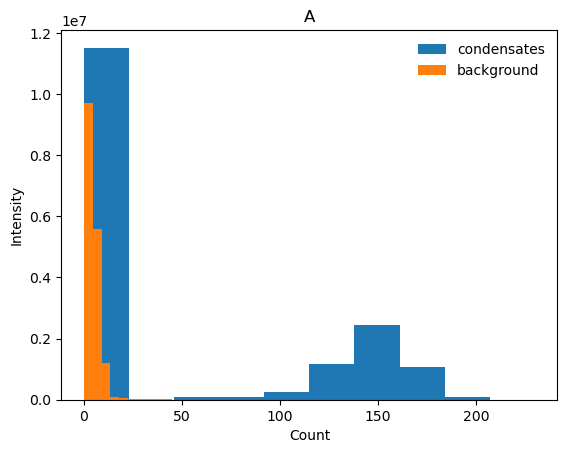


    Average value of dilute phase (background) to condensed phase (condensates) intensity = 0.08829709817952511
    


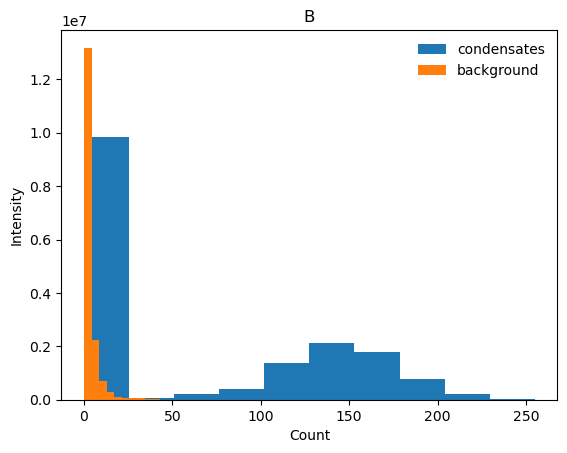


    Average value of dilute phase (background) to condensed phase (condensates) intensity = 0.0464854983233169
    


In [8]:
# Compute reference values in confocal micrographs
confocal_ratios = {}
for (image, mask), label in zip(zip([image_A, image_B], [mask_A, mask_B]), ["A", "B"]): 
    # Intersect with inverted mask (mask shows dark condensates, bright background) to get condensates
    condensates = cv2.bitwise_and(image, ~mask)
    background = cv2.bitwise_and(image, mask)
    # Plot histogram 
    plt.hist(condensates.reshape(-1), label = 'condensates')
    plt.hist(background.reshape(-1), label = 'background')
    plt.title(label)
    plt.xlabel('Count')
    plt.ylabel('Intensity')
    plt.legend(frameon=False)
    plt.show()
    ratio = np.mean(background)/np.mean(condensates)
    confocal_ratios[label] = ratio
    print(f"""
    Average value of dilute phase (background) to condensed phase (condensates) intensity = {ratio}
    """)

# Plot

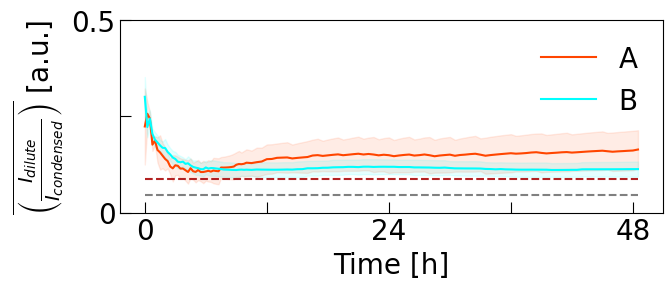

In [9]:
# Plot - Figure S16
plt.figure(figsize = (7, 2.5))
# A
# Mean profile (between 3 FOVs)
plt.plot(
    timepoints[0:]/60, 
    np.mean(ratio_A, axis = 0)[0:],
    color = 'orangered', 
    label = 'A'
)
# Shaded region for standard deviation (between 3 FOVs)
plt.fill_between(
    timepoints[0:]/60, 
    np.mean(ratio_A, axis = 0)[0:] - np.std(ratio_A, axis = 0)[0:], 
    np.mean(ratio_A, axis = 0)[0:] + np.std(ratio_A, axis = 0)[0:], 
    color = 'orangered', 
    alpha = 0.1
)
# Plot reference from confocal
plt.hlines(confocal_ratios["A"], 0, 48.5, color = 'firebrick', ls = '--')

# B
# Mean profile (between 3 FOVs)
plt.plot(
    timepoints[0:]/60, 
    np.mean(ratio_B, axis = 0)[0:], 
    color = 'cyan', 
    label = 'B'
)
# Shaded region for standard deviation (between 3 FOVs)
plt.fill_between(
    timepoints[0:]/60, 
    np.mean(ratio_B, axis = 0)[0:] - np.std(ratio_B, axis = 0)[0:], 
    np.mean(ratio_B, axis = 0)[0:] + np.std(ratio_B, axis = 0)[0:], 
    color = 'cyan', 
    alpha = 0.1
)
# Plot reference from confocal
plt.hlines(confocal_ratios["B"], 0, 48.5, ls = '--', color = 'gray')

# Select xticks, yticks and label axes
plt.xticks([0, 12, 24, 36, 48], [0, '', 24, '', 48], fontsize = 20)
plt.yticks([0, 0.25, 0.5], [0, '', 0.50], fontsize = 20)
plt.xlabel('Time [h]', fontsize = 20)
plt.ylabel(r'$\overline{\left(\frac{I_{dilute}}{I_{condensed}}\right)}$ [a.u.]', fontsize = 20)
plt.gca().tick_params(direction = 'in', length = 8)
plt.legend(frameon = False, fontsize = 20)
plt.show()